In [152]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [153]:
dataset = pd.read_excel('data/data.xlsx')
empty_data = dataset.dropna(how='all')
empty_data = empty_data.dropna(axis=1,how='all')
empty_data = empty_data.drop([0])
empty_data = empty_data.reset_index()
empty_data = empty_data.drop(columns=['L,p','index'])
dataset = empty_data

In [154]:
dataset

,wiek,rozpoznanie,dziewczynki/chłopcy,masa ciała,wzrost,BMI,centyl,średnia dla wieku,SD populacji,Z score BMI,...,EPA,C22:2n-6,C22:4n-6,C22:5n-6,C24:0,C24:1n-9,C22:5n-3,DHA,AA/DGLA,DGLA/LA
0,16.282192,s,NaN,94.5,1.65,34.710744,97,20.79,2.50,5.568298,...,0.567,0.112,0.196,0.158,0.151,0.436,1.547,1.68,0.881664,0.226844
1,13.432877,s,D,67.0,1.60,26.171875,96,19.10,2.75,2.571591,...,0.390,0.250,0.280,0.150,0.130,0.670,1.310,2.52,3.193548,0.161374
2,11.879452,s,D,70.0,1.56,28.763971,NaN,NaN,NaN,NaN,...,0.950,0.330,0.510,0.130,0.210,0.600,1.710,1.85,2.092457,0.222764
3,10.904110,s,C,62.0,1.45,29.488704,NaN,NaN,NaN,NaN,...,0.270,0.240,0.470,0.410,0.250,0.430,1.610,2.23,1.568849,0.243139
4,18.265753,s,D,79.5,1.72,26.872634,97,21.64,2.69,1.945217,...,0.910,0.190,0.300,0.250,0.470,1.050,1.410,2.98,1.467967,0.170871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,NaN,o,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.160,0.190,0.390,0.830,0.140,0.630,0.610,2.25,3.940678,0.131623
273,2.270000,o,C,25.0,0.98,26.030820,NaN,NaN,NaN,NaN,...,0.320,0.340,0.410,0.860,0.160,0.810,0.520,2.03,3.004695,0.107903
274,16.800000,o,D,90.0,1.74,29.900000,97,21.10,2.52,3.491308,...,0.150,0.250,0.280,0.890,0.410,0.840,0.700,1.68,1.944444,0.154589
275,NaN,o,D,66.0,1.65,24.240000,NaN,NaN,NaN,NaN,...,0.180,0.210,0.300,0.970,0.280,1.200,0.630,1.48,2.862745,0.155773


In [155]:
#Set equal label type for sick people
for i, row in dataset.iterrows():
    label = row['rozpoznanie']
    if label == ' s':
        dataset.at[i,'rozpoznanie'] = 's'
    elif label == 'S':
        dataset.at[i,'rozpoznanie'] = 's'

In [157]:
#For rows where there is no age or weight, put random age generated from normal distribution with mean age and standard deviation of age
nr_of_both_nan = 0
mean_age = dataset[['wiek']].mean()
std_age = dataset[['wiek']].std()
for i, row in dataset.iterrows():
    (weight, age) = row[['masa ciała','wiek']]
    if pd.isnull(weight) and pd.isnull(age):
        new_age = np.random.normal(mean_age,std_age)
        dataset.at[i,'wiek'] = new_age
        nr_of_both_nan+=1
nr_of_both_nan

0

<Axes: xlabel='wiek', ylabel='Count'>

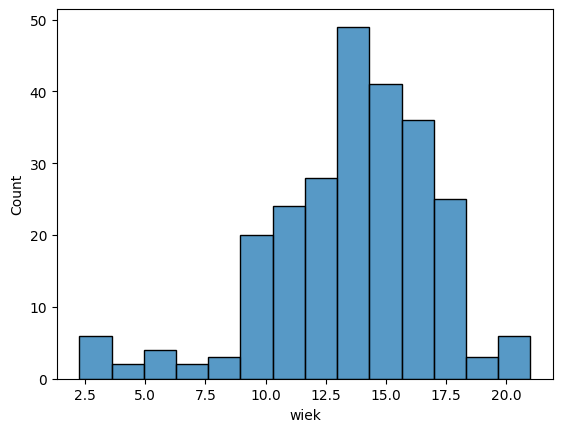

In [158]:
sns.histplot(data=dataset, x='wiek') 

In [159]:
#Count no-age
nr_of_no_age = 0
mean_age = dataset[['wiek']].mean()
std_age = dataset[['wiek']].std()
for i, row in dataset.iterrows():
    (weight, age) = row[['masa ciała','wiek']]
    if not(pd.isnull(weight)) and pd.isnull(age):
        nr_of_no_age+=1
nr_of_no_age

28

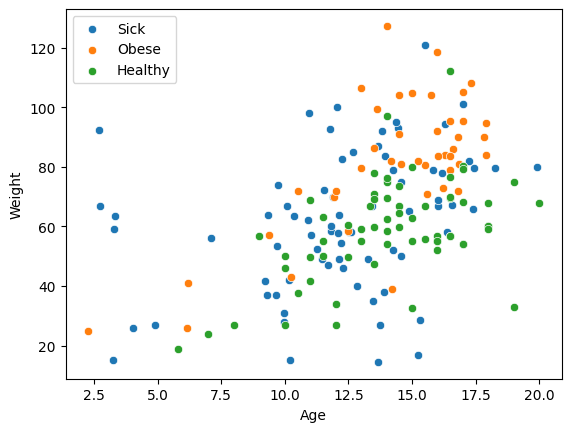

In [151]:
sick = dataset[['wiek','masa ciała', 'rozpoznanie']][(dataset['rozpoznanie']=='s')]
obese = dataset[['wiek','masa ciała', 'rozpoznanie']][(dataset['rozpoznanie']=='o')]
healthy = dataset[['wiek','masa ciała', 'rozpoznanie']][(dataset['rozpoznanie']=='k')]
sns.scatterplot(data=sick, x = 'wiek', y='masa ciała', label= 'Sick')
sns.scatterplot(data=obese, x = 'wiek', y='masa ciała', label = 'Obese' )
sns.scatterplot(data=healthy, x = 'wiek', y='masa ciała', label = 'Healthy')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.legend(loc=2)